In [1]:
# Loading libraries for the course
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations
from skimage import filters, measure, segmentation, color
from scipy.ndimage import gaussian_filter
from skimage.filters import difference_of_gaussians
import pandas as pd
from cellpose import models

In [2]:
# Loading data
drug_name = ['Drug' + str(i) for i in range(1, 11)]

figName = '../Drug7_1000nM/rep1_FOV1.tif'
img = imread(str(figName))


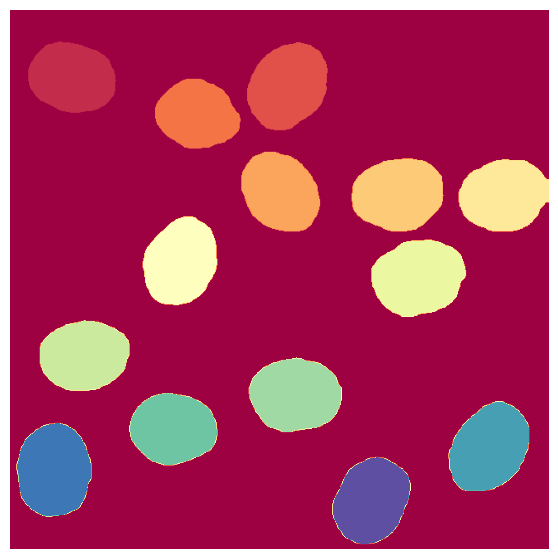

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


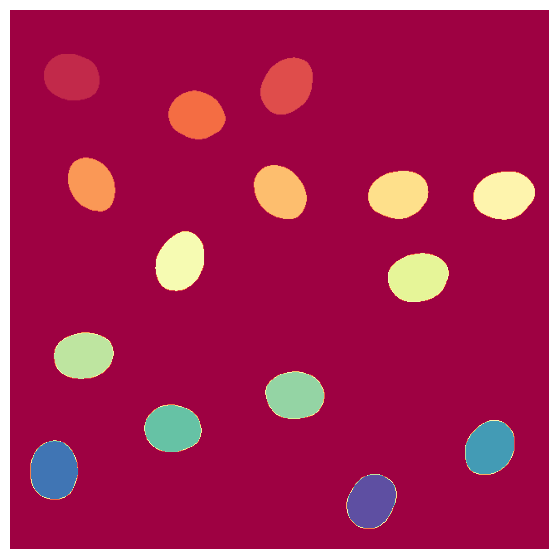

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [4]:
## Segmentation of cells and nucleus ———— to be replaced 

test1 = img[0, :, :, 1] # 'test1' to be changed
model1 = models.Cellpose(gpu = False, model_type = 'nuclei')

# Apply the model to your image
masks_cyto, flows, styles, diams = model1.eval(test1, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(figsize=(20, 7))
ax.imshow(masks_cyto,cmap='Spectral')
ax.axis('off')
plt.show()
print('Values in mask: ', np.unique (masks_cyto))

test2 = img[0, :, :, 0]
model2 = models.Cellpose(gpu = False, model_type = 'cyto')

# Apply the model to your image
masks_nuc, flows, styles, diams = model2.eval(test2, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(figsize=(20, 7))
ax.imshow(masks_nuc,cmap='Spectral')
ax.axis('off')
plt.show()
print('Values in mask: ', np.unique (masks_nuc))

In [64]:
# Make sure that one cell has the same id in both masks
# Get the unique labels in the cell and nucleus masks
cell_labels = np.unique(masks_cyto)
nucleus_labels = np.unique(masks_nuc)

# Initialize the mapping table
mapping_table = {}

# Loop through each cell label
for cell_label in cell_labels:
    # Skip the background
    if cell_label == 0:
        continue

    # Get the mask for the current cell
    current_cell_mask = (masks_cyto == cell_label)

    # Loop through each nucleus label
    for nucleus_label in nucleus_labels:
        # Skip the background
        if nucleus_label == 0:
            continue

        # Get the mask for the current nucleus
        current_nucleus_mask = (masks_nuc == nucleus_label)

        # If the current cell and the current nucleus overlap, add them to the mapping table
        if np.any(current_cell_mask & current_nucleus_mask):
            mapping_table[cell_label] = nucleus_label
            break
updated_masks_nuc = masks_nuc.copy()

# Loop through each item in the mapping table
for cell_label, nucleus_label in mapping_table.items():
    # Update the nucleus label in the nucleus mask
    updated_masks_nuc[masks_nuc == nucleus_label] = cell_label
masks_nuc = updated_masks_nuc

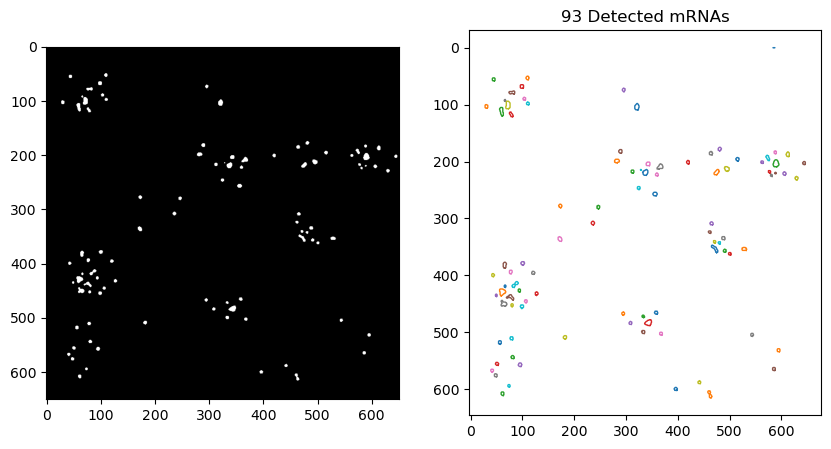

In [36]:
# mRNA identification
threshold_m = 0.025

fig, ax = plt.subplots(1,2,figsize=(10, 5))

mRNA = img[0, :, :, 2]
mRNA_filtered = difference_of_gaussians(mRNA,low_sigma=1, high_sigma=5)

mRNA_binary = mRNA_filtered.copy()
mRNA_binary[mRNA_binary>=threshold_m] = threshold_m # Making spots above the threshold equal to the threshold value.
mRNA_binary[mRNA_binary<threshold_m] = 0 # Making spots below the threshold equal to 0.

mRNA_binary[mRNA_binary!=0] = 1 # Binarization
ax[0].imshow(mRNA_binary, cmap='gray')
spot_contours = measure.find_contours(mRNA_binary, 0.9)

for contour in spot_contours:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1)
ax[1].set(title= str(len(spot_contours))+' Detected mRNA spots' )
ax[1].invert_yaxis()
plt.show()

labels_m = measure.label(mRNA_binary)


In [6]:
# Counting the detected mRNA spots in each cell and nuclei
# Note that one mRNA spot detected here may contain more than one mRNA molecule, for example the transcription site
number_detected_cells = np.max(masks_cyto)
list_cytosol_particles = np.zeros(number_detected_cells)
list_nuclear_particles = np.zeros(number_detected_cells)

nucleus_indices = np.zeros(np.max(masks_cyto)+1)
for i in range(1,np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

# Loop through the cytosol masks
for i in range(len(spot_contours)):
    # Find the position of the particle
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    # Check which cyto mask is the particle in
    cell_num = masks_cyto[posn[0], posn[1]]
    if cell_num>0:
        list_cytosol_particles[cell_num-1] += 1

        # Check if the particle is also in the nucleus
        if masks_nuc[posn[0], posn[1]] == nucleus_indices[cell_num]:
            list_nuclear_particles[cell_num-1] += 1

# Add the number of particles to the dataframe
df = pd.DataFrame([])
df['mRNAs in cytosol'] = list_cytosol_particles
df['mRNAs in nucleus'] = list_nuclear_particles
df

,mRNAs in cytosol,mRNAs in nucleus
0,10.0,5.0
1,2.0,1.0
2,0.0,0.0
3,10.0,5.0
4,5.0,2.0
5,11.0,6.0
6,4.0,0.0
7,9.0,5.0
8,16.0,6.0
9,7.0,3.0


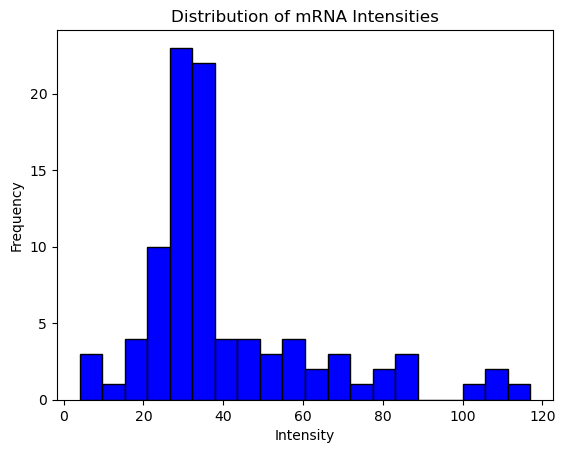

28.564102564102566

In [70]:
# Use foci size to calculate the number of mRNAs in each detected spot

props = measure.regionprops(labels_m, intensity_image=mRNA)

# Initialize a list to store the intensities
intensities = []
areas = []

# Loop through each mRNA in the image
for prop in props:
    # Calculate the area of the current mRNA spot and add it to the list
    areas.append(prop.area)
# Plot the distribution of intensities
plt.hist(areas, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of mRNA spot areas')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

# Calculate the area of a single mRNA molecule
areas = np.array(areas)
areas_sorted = np.sort(areas)
start = np.percentile(areas_sorted, 10) # select areas between 10th and 50th percentile
end = np.percentile(areas_sorted, 50)
selected_areas = areas_sorted[(areas_sorted>=start) & (areas_sorted<=end)]
single_mRNA_area = np.mean(selected_areas)

In [80]:
# get the number of mRNAs molecules in the nucleus
cell_id = np.unique(masks_cyto)
df_m_c = pd.DataFrame(columns=['Cell Label', 'Total mRNA Area', 'mRNA Count in Nucleus'])

for id in cell_id:
    # Skip the background
    if id == 0:
        continue

    # Get the mask for the current cell
    nuc_mask = (masks_nuc == id)

    # Calculate the properties of the mRNAs in the current cell
    props = measure.regionprops(labels_m * nuc_mask, intensity_image = mRNA)

    # Initialize the total area, total intensity and count for the current cell
    total_area = 0
    count = 0

    # Loop through each mRNA in the current cell
    for prop in props:
        # Update the total area, total intensity and count
        total_area += prop.area

    count = round(total_area / single_mRNA_area)
    # Add the results for the current cell to the DataFrame
    df_m_c.loc[len(df_m_c)] = [id, total_area, count]
df_m_c

,Cell Label,Total mRNA Area,mRNA Count in Nucleus
0,1.0,247.0,9.0
1,2.0,83.0,3.0
2,3.0,0.0,0.0
3,4.0,204.0,7.0
4,5.0,136.0,5.0
5,6.0,219.0,8.0
6,7.0,1.0,0.0
7,8.0,136.0,5.0
8,9.0,317.0,11.0
9,10.0,163.0,6.0


In [79]:
# get the number of mRNAs molecules in the cytoplasm
df_m_c = pd.DataFrame(columns=['Cell Label', 'Total mRNA Area', 'mRNA Count in Cytoplasm'])

for id in cell_id:
    # Skip the background
    if id == 0:
        continue

    # Get the mask for the current cell
    mask_c = (masks_cyto == id)
    mask_n = (masks_nuc == id)
    cyto_mask = mask_c & ~mask_n

    # Calculate the properties of the mRNAs in the current cell
    props = measure.regionprops(labels_m * cyto_mask, intensity_image = mRNA)

    # Initialize the total area, total intensity and count for the current cell
    total_area = 0
    count = 0

    # Loop through each mRNA in the current cell
    for prop in props:
        # Update the total intensity and count
        total_area += prop.area

    count = round(total_area / single_mRNA_area)
    # Add the results for the current cell to the DataFrame
    df_m_c.loc[len(df_m_c)] = [id, total_area, count]
df_m_c

,Cell Label,Total mRNA Area,mRNA Count in Cytoplasm
0,1.0,227.0,8.0
1,2.0,25.0,1.0
2,3.0,0.0,0.0
3,4.0,211.0,8.0
4,5.0,98.0,4.0
5,6.0,180.0,6.0
6,7.0,139.0,5.0
7,8.0,163.0,6.0
8,9.0,375.0,13.0
9,10.0,113.0,4.0
